# Increasing noise BDAE (Linear)


## Data loading and processing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
!pip install -q tensorflow
%load_ext tensorboard

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
trainval_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17789239.20it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499763.57it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4471616.43it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3677708.26it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [5]:
train_data, val_data = random_split(trainval_data, [50_000, 10_000])

# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

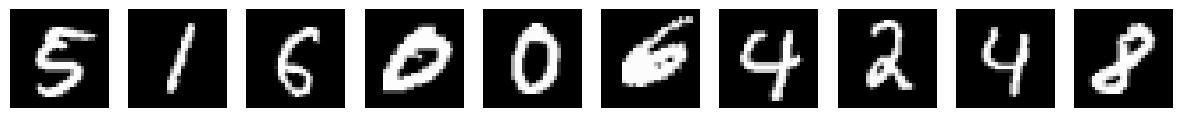

In [6]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

In [7]:
dropout_rate = 0.3

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

class LinearBDAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 512)
        self.enc_fc2 = nn.Linear(512, 256)
        self.enc_fc3 = nn.Linear(256, 128)

        # Decoder layers
        self.dec_fc1 = nn.Linear(128, 256)
        self.dec_fc2 = nn.Linear(256, 512)
        self.dec_fc3 = nn.Linear(512, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var

## Noise schemes

In [8]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Training Process

### Training functions

In [9]:
def train(train_loader, net, optimizer, criterion, noise_factor):
  total_loss = 0

  for i, data in enumerate(train_loader):

        images, _ = data
        images = images.view(images.size(0), -1)

        # ADD NOISE PROCESS
        corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

        images = images.to(device)
        corrupted_images = corrupted_images.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(corrupted_images)

        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        total_loss += loss.item() * images.size(0)

  avg_loss = total_loss/len(train_loader.dataset)  # Compute average loss

  return avg_loss

In [10]:
def validation(val_loader, net, criterion, Nsamples, noise_factor):
  total_loss = 0

  # Use torch.no_grad to skip gradient calculation, not needed for evaluation
  with torch.no_grad():
      # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            # images = images.to(device)
            images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # keep track of loss and accuracy
            total_loss += loss.item() * images.size(0)

  return total_loss/len(val_loader.dataset)

### Training Procedure

##### Noise factor = 0 (no noise)

In [12]:
#Set random seed
torch.manual_seed(42)

linear_model_00 = LinearBDAE().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(linear_model_00.parameters(), lr=learning_rate)

noise_factor = 0

num_epochs = 25

Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, linear_model_00, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 25/25 [03:32<00:00,  8.51s/it]

Finished Training


##### Noise factor = 0.2

In [13]:
linear_model_02 = LinearBDAE().to(device)
criterion = nn.MSELoss()
# learning_rate = 1e-3
optimizer = torch.optim.Adam(linear_model_02.parameters(), lr=learning_rate)

noise_factor = 0.2

# num_epochs = 1

# Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, linear_model_02, optimizer, criterion, noise_factor)

print('Finished Training')


100%|██████████| 25/25 [03:23<00:00,  8.15s/it]

Finished Training


##### Noise factor = 0.4

In [14]:
linear_model_04 = LinearBDAE().to(device)
criterion = nn.MSELoss()
# learning_rate = 1e-3
optimizer = torch.optim.Adam(linear_model_04.parameters(), lr=learning_rate)

noise_factor = 0.4

# num_epochs = 1

# Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, linear_model_04, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 25/25 [03:23<00:00,  8.16s/it]

Finished Training


##### Noise factor = 0.6

In [15]:
linear_model_06 = LinearBDAE().to(device)
criterion = nn.MSELoss()
# learning_rate = 1e-3
optimizer = torch.optim.Adam(linear_model_06.parameters(), lr=learning_rate)

noise_factor = 0.6

# num_epochs = 1

# Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, linear_model_06, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 25/25 [03:24<00:00,  8.17s/it]

Finished Training


##### Noise factor = 0.5

In [13]:
linear_model_05 = LinearBDAE().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(linear_model_05.parameters(), lr=learning_rate)

noise_factor = 0.5

num_epochs = 5

Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, linear_model_05, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 5/5 [02:06<00:00, 25.36s/it]

Finished Training


## Visualizations Linear

### Clean images

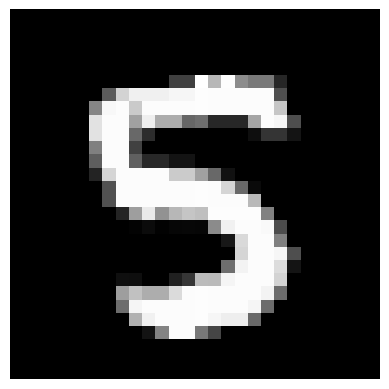

In [14]:
# Specify the index of the image you want to retrieve
i = 120  # Change this index to get a different image

# Retrieve the i-th image and its label
image, _ = test_data[i]

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

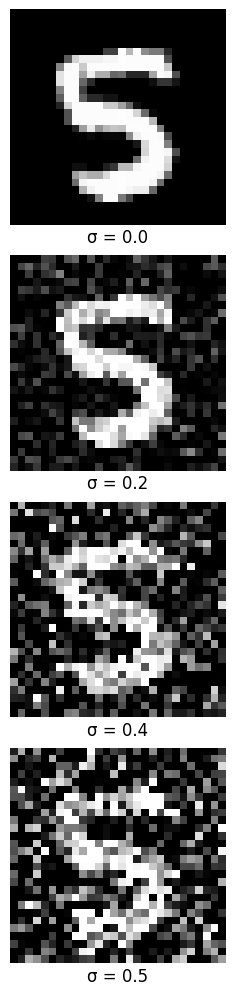

In [48]:
# Define the noise levels
noise_levels = [0.0, 0.2, 0.4, 0.5]
# noise_levels = [0.0, 0.2, 0.4, 0.6]

# Create a plot of 4 rows by 1 column
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

noisy_images = []

# Plot the images with different levels of Gaussian noise
for idx, noise_level in enumerate(noise_levels):
    noisy_image = add_gaussian_noise(image, noise_factor=noise_level)
    noisy_images.append(noisy_image)

    axs[idx].imshow(noisy_image.squeeze(), cmap='gray')
    axs[idx].set_title(f"σ = {noise_level}", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

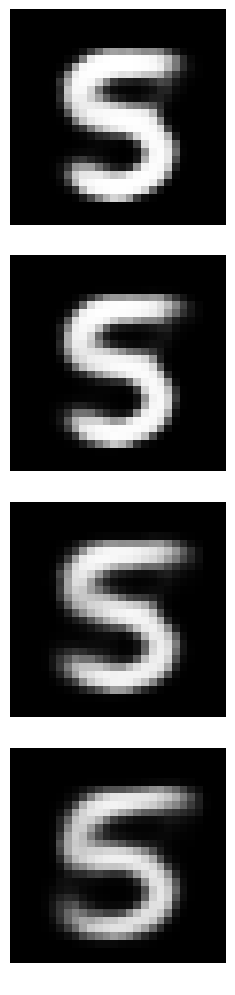

In [49]:
# Define the noise levels and corresponding models
models = [linear_model_05, linear_model_05, linear_model_05, linear_model_05]  # Replace with your actual models
# models = [linear_model_00, linear_model_02, linear_model_04, linear_model_06]

# Apply noise and denoise images
denoised_means = []
denoised_vars = []


for corrupted_image, model in zip(noisy_images, models):
    model.eval()
    predictions, predictions_mean, predictions_var = model.sample_predict(corrupted_image.view(-1, 28*28).to(device), 100)  # Assuming model takes a batch of images
    denoised_means.append(predictions_mean.view(28,28).cpu().detach().numpy())
    denoised_vars.append(predictions_var.view(28,28).cpu().detach().numpy())

# Create a plot of 4 rows by 1 column for denoised images
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Plot the denoised images
for idx, denoised_image in enumerate(denoised_means):
    axs[idx].imshow(denoised_image, cmap='gray', vmax=1)
    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

0.08271138
0.059058703
0.035255842
0.026684625


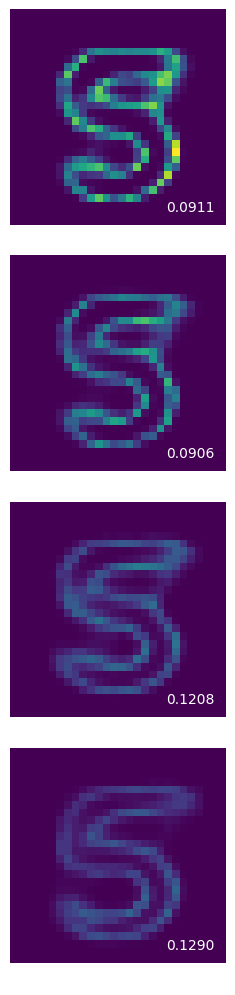

In [51]:
# Create a plot of 4 rows by 1 column for denoised images
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Plot the denoised images
for idx, denoised_image in enumerate(denoised_vars):

    print(np.max(denoised_image))

    mean_variance = np.mean(denoised_image)/np.max(denoised_image)

    axs[idx].imshow(denoised_image, cmap='viridis', vmax=0.083)
    axs[idx].text(0.95, 0.05, f'{mean_variance:.4f}', size=10, ha='right', va='bottom', color='white', transform=axs[idx].transAxes)
    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

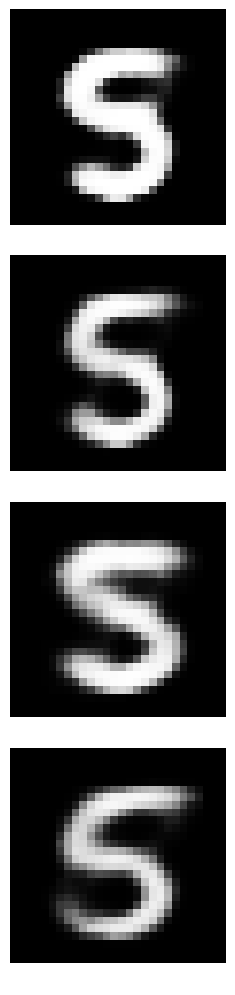

In [52]:


# Apply noise and denoise images
denoised_means = []
denoised_vars = []


for corrupted_image, model in zip(noisy_images, models):
    model.eval()
    predictions = model(corrupted_image.view(-1, 28*28).to(device))  # Assuming model takes a batch of images
    denoised_means.append(predictions.view(28,28).cpu().detach().numpy())
    # denoised_vars.append(predictions_var.view(28,28).cpu().detach().numpy())

# Create a plot of 4 rows by 1 column for denoised images
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Plot the denoised images
for idx, denoised_image in enumerate(denoised_means):
    axs[idx].imshow(denoised_image, cmap='gray', vmax=1)
    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

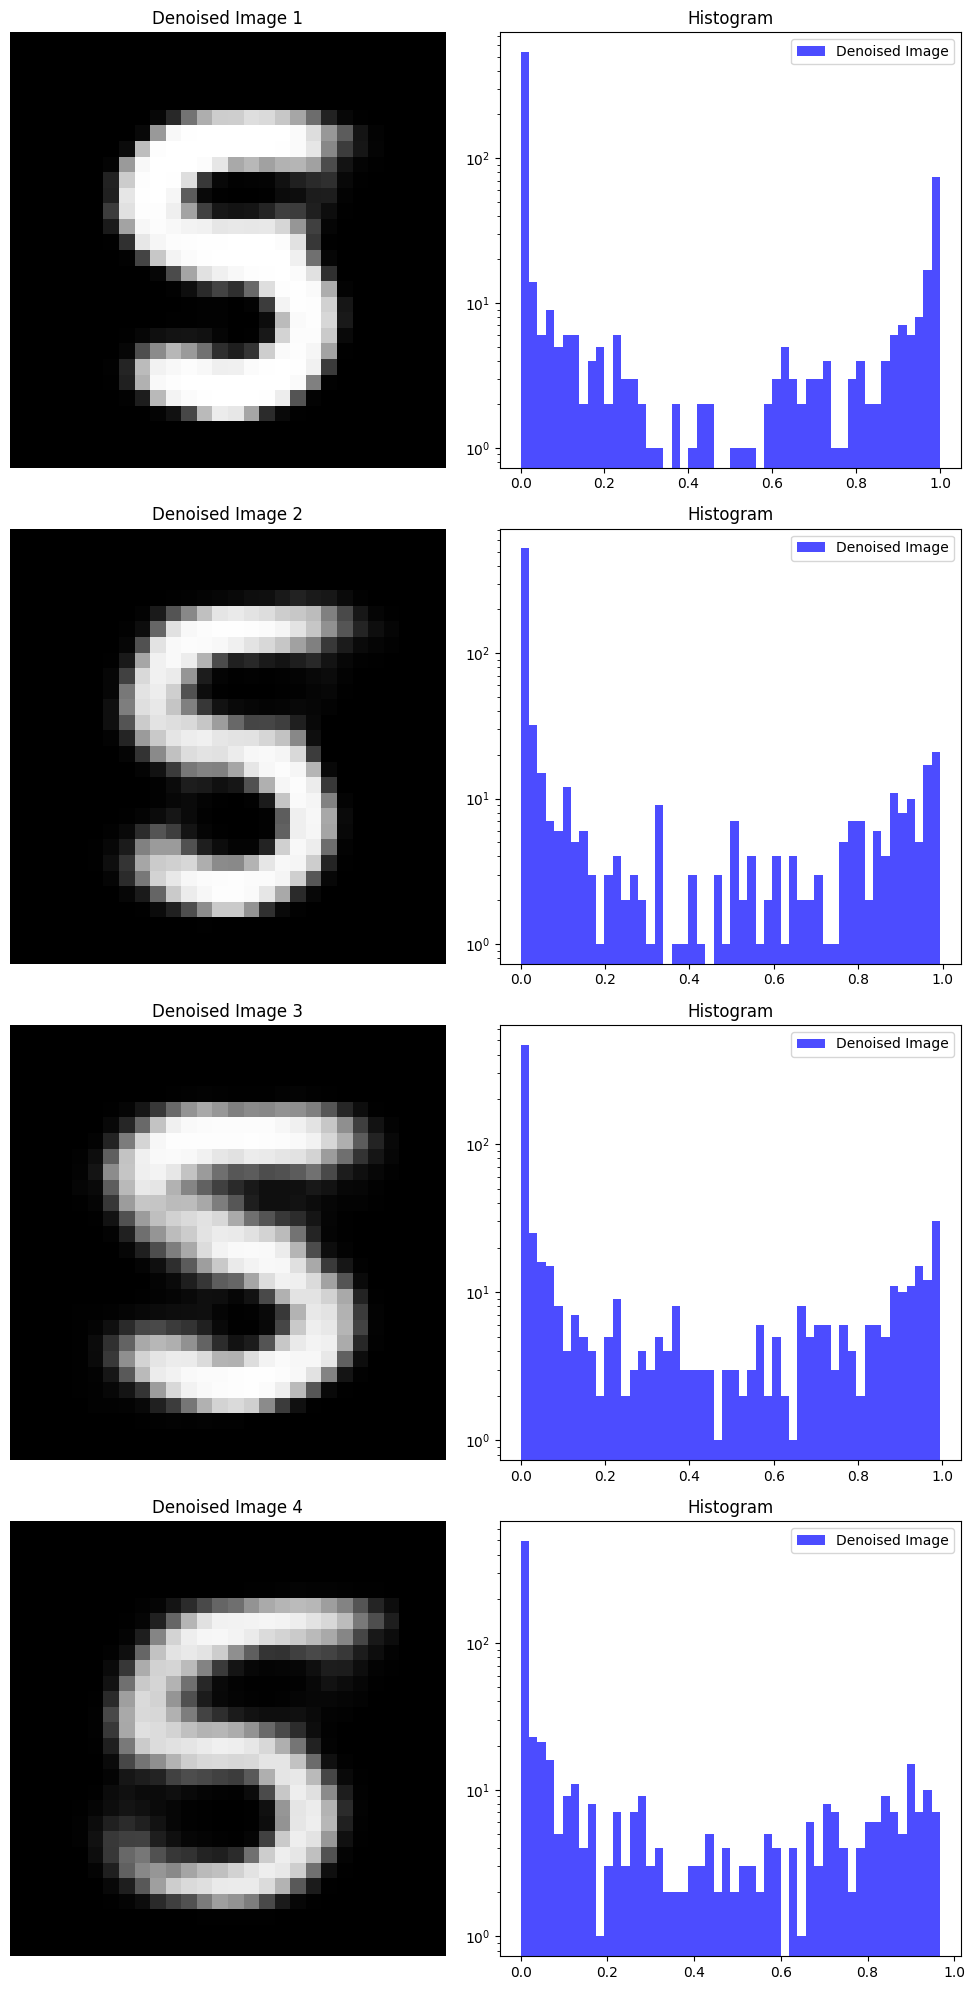

In [53]:
# Initialize figure and axes
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

# Plot denoised images and histograms
for idx, (denoised_image, noisy_image) in enumerate(zip(denoised_means, noisy_images)):
    # Plot denoised image
    axs[idx, 0].imshow(denoised_image, cmap='gray', vmax=1)
    axs[idx, 0].set_title(f"Denoised Image {idx+1}")
    axs[idx, 0].axis('off')

    # Plot histogram
    axs[idx, 1].hist(denoised_image.flatten(), bins=50, color='blue', alpha=0.7, label='Denoised Image')
    # axs[idx, 1].hist(noisy_image.cpu().detach().numpy().flatten(), bins=50, color='red', alpha=0.5, label='Noisy Image')
    axs[idx, 1].set_title("Histogram")
    axs[idx, 1].set_yscale('log')  # Set logarithmic scale
    axs[idx, 1].legend()

# Show the plot
plt.tight_layout()
plt.show()